In [1]:
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np

In [12]:
cfg = Config.fromfile('./_swin_faster_config.py')

cfg.data.test.test_mode = True

In [13]:
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=cfg.data.samples_per_gpu,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [14]:
epoch = 'latest'

In [15]:
checkpoint_path = os.path.join(cfg.work_dir, f'{epoch}.pth')

model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg'))
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu')

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

load checkpoint from local path: ./work_dirs/_swin_faster/latest.pth


In [16]:
output = single_gpu_test(model, data_loader, show_score_thr=0.05)

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4871/4871, 4.8 task/s, elapsed: 1009s, ETA:     0s

In [17]:
# convert output into submission file

prediction_strings = []
file_names = []
coco = COCO(cfg.data.test.ann_file)
img_ids = coco.getImgIds()

class_num = 10
for i, out in enumerate(output):
    prediction_string = ''
    image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]
    for j in range(class_num):
        for o in out[j]:
            prediction_string += str(j) + ' ' + str(o[4]) + ' ' + str(o[0]) + ' ' + str(o[1]) + ' ' + str(
                o[2]) + ' ' + str(o[3]) + ' '
        
    prediction_strings.append(prediction_string)
    file_names.append(image_info['file_name'])

submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv(os.path.join(cfg.work_dir, f'submission_{epoch}.csv'), index=None)
submission

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


,PredictionString,image_id
0,0 0.7566364 475.80936 588.58765 561.8712 664.6...,test/0000.jpg
1,0 0.039909475 353.76315 241.60619 754.8352 702...,test/0001.jpg
2,0 0.99281585 877.133 462.80215 1018.95465 628....,test/0002.jpg
3,0 0.059650626 12.683563 176.06241 1006.57153 9...,test/0003.jpg
4,0 0.9822702 446.7928 403.58582 653.1003 561.55...,test/0004.jpg
...,...,...
4866,0 0.9348727 293.59967 350.52682 673.2529 687.6...,test/4866.jpg
4867,0 0.8186238 627.09924 668.68396 769.4575 722.1...,test/4867.jpg
4868,0 0.041709173 543.16504 528.9567 698.10364 784...,test/4868.jpg
4869,0 0.85047436 2.3905945 172.00275 998.1156 948....,test/4869.jpg


2068
0 General trash
1 Paper
19 55 943 839 0.9929554
2 Paper pack
3 Metal
4 Glass
5 Plastic
6 Styrofoam
7 Plastic bag
0 423 390 893 0.9996613
2 284 59 317 0.5476512
8 Battery
9 Clothing


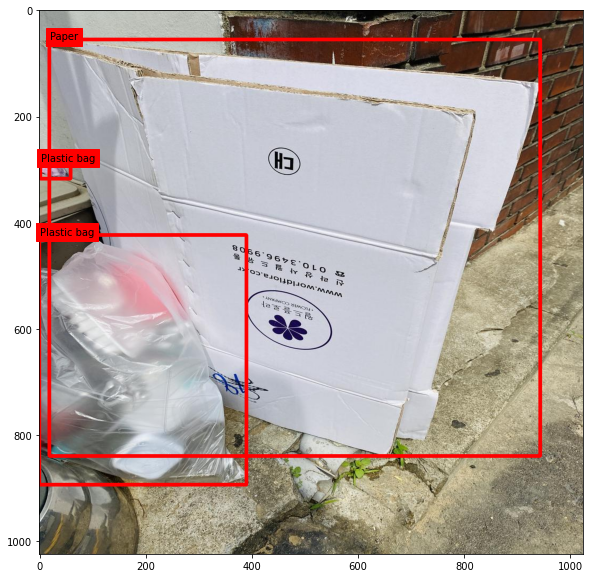

In [92]:
import matplotlib.pyplot as plt
import cv2

i = np.random.randint(0, 4871)
print(i)

root = '../../dataset/'
image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]
img_name = os.path.join(root, image_info['file_name'])

img = cv2.imread(img_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

out = output[i]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for clss in range(class_num):
    print(clss, cfg.classes[clss])

    for out_per_clss in out[clss]:
        left, top, right, bottom, score = out_per_clss
        left, top, right, bottom = map(int, [left, top, right, bottom])
                
        if score>=0.5:
            print(left, top, right, bottom, score)
            img = cv2.rectangle(img, (left, top), (right, bottom), (255, 0, 0), 5)
            ax.text(x=left, y=top, s=cfg.classes[clss], backgroundcolor='red')

plt.imshow(img)

plt.show()